# RAFDB data perparation notebook

The data is split into basic and compound folders for basic emotions and compound emotions. 

We will be omitting the compound emotions and focus on the basic emotions.
```text

basic:
|
|---Annotation
|---EmoLabel
|---Feature
|---Image
|---README.txt

The annotation folder has a boundingbox.zip file containing the bounding boxes for the images.
This will be used to extract the images and align them. 

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, shutil
os.chdir('..')
from utility_scripts.adaface_utils.face_alignment.align import get_aligned_face

In [2]:
bounding_boxes_path = os.path.join('data', 'datasets', 'emotion recognition', 'RAF_DB', 'RAF_DB', 'basic', 'Annotation', 'boundingbox')
os.path.exists(bounding_boxes_path)

True

In [3]:
original_images_path = os.path.join('data', 'datasets', 'emotion recognition', 'RAF_DB', 'RAF_DB','basic', 'Image', 'original')
os.path.exists(original_images_path)

True

In [4]:
landmarks_path = os.path.join('data', 'datasets', 'emotion recognition', 'RAF_DB', 'RAF_DB', 'basic', 'Annotation', 'manual')
os.path.exists(landmarks_path)

True

In [5]:
labels_path = os.path.join('data', 'datasets', 'emotion recognition', 'RAF_DB', 'RAF_DB', 'basic', 'EmoLabel', 'list_patition_label.txt')
os.path.exists(labels_path)

True

In [6]:
image_paths = []
for image_path in sorted(os.listdir(original_images_path)):
    image_paths.append(os.path.join(original_images_path, image_path))

In [7]:
bounding_boxes_paths = []
for box_file in sorted(os.listdir(bounding_boxes_path)):
    bounding_boxes_paths.append(os.path.join(bounding_boxes_path, box_file))

In [8]:
landmarks_paths = []
for landmark_path in sorted(os.listdir(landmarks_path)):
    landmarks_paths.append(os.path.join(landmarks_path, landmark_path))

In [10]:
label_translation_to_affectnet = { # translated the labels from the RAF format to the AffectNet format
    1 : 3,
    2 : 4,
    3 : 5,
    4 : 1,
    5 : 2,
    6 : 6,
    7 : 0
}

label_translation_to_text = {
    0 : 'neutral',
    1 : 'happy',
    2 : 'sad',
    3 : 'surprise',
    4 : 'fear',
    5 : 'disgust',
    6 : 'anger'
}

In [10]:
with open(labels_path, 'r', encoding = 'utf8') as labels_file:
    lines = sorted(labels_file.readlines())

labels = []
translated_labels = []
train_test_splits = []
image_names = []
for line in lines:
    line = line.replace('\n', '')
    image_name, label = line.split(' ')
    split = 'train' if 'train' in image_name else 'test'
    
    image_names.append(image_name)
    labels.append(label_translation_to_affectnet[int(label)])
    translated_labels.append(label_translation_to_text[labels[-1]])
    train_test_splits.append(split)

In [11]:
import cv2

In [12]:
bounding_boxes = []
images = []
landmarks = []
for i in range(len(bounding_boxes_paths)):
    image_path = image_paths[i]
    box_path = bounding_boxes_paths[i]
    landmark_path = landmarks_paths[i]

    # Verify both the image path and the bounding box path have the same image ID
    image_name = os.path.split(image_path)[1].split('.jpg')[0]
    if image_name not in box_path:
        raise RuntimeError(f'The box path does not correspond to the given image. image_path: {image_path}, box_path: {box_path}')

    # Verify both the image path and the landmark path have the same image ID
    if image_name not in landmark_path:
        raise RuntimeError(f'The landmark path does not correspond to the given image. image_path: {image_path}, landmark_path: {landmark_path}')
    
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Read bounding box
    with open(box_path, 'r', encoding = 'utf8') as box_file:
        line = box_file.readline()
        box = line.split(' ')[:-1] # split using the space and get rid of the white space at the end
        box = [float(pt) for pt in box]
    
    # Read landmarks
    with open(landmark_path, 'r', encoding = 'utf8') as landmark_file:
        lines = landmark_file.readlines()[:-3] # Ignore the last three lines
        
        landmark_points = []
        for line in lines:
            line = line.replace('\n', '')
            if '\t' in line:
                line = line.split('\t')
            else:
                line = line.split(' ')
            line = [float(pt) for pt in line]
            landmark_points.append(line)
        
    images.append(image)
    bounding_boxes.append(box)
    landmarks.append(landmark_points)

### Check the bounding boxes

In [13]:
import cv2
import numpy as np
import math

def align_face_rotation_bbox(img, landmarks, bbox, target_size=(112, 112), padding_factor=0.1):
    """
    Aligns face by rotating to make eyes horizontal and cropping the bounding box.
    
    Args:
        img: Original image (H, W, C)
        landmarks: 5x2 array (Eye_L, Eye_R, Nose, Mouth_L, Mouth_R)
        bbox: [x1, y1, x2, y2]
        target_size: tuple (112, 112)
        padding_factor: Float, expands the bbox slightly (e.g., 0.1 = 10% larger)
    """
    
    # 1. Calculate the Angle between Eyes
    left_eye = landmarks[0]
    right_eye = landmarks[1]
    
    # Delta x and Delta y
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    
    # Calculate angle in degrees
    angle = np.degrees(np.arctan2(dy, dx))
    
    # 2. Get Rotation Matrix
    # We rotate around the center of the face (estimated by landmark center or image center)
    # Using the nose (index 2) or the midpoint of eyes as the pivot is safer than image center
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
    
    # 3. Rotate the Image
    h, w = img.shape[:2]
    rotated_img = cv2.warpAffine(img, M, (w, h))
    
    # 4. Rotate the Bounding Box Points to find the new crop area
    # We must transform the bbox corners to the new rotated coordinate system
    # BBox format: x1, y1, x2, y2
    bbox_points = np.array([
        [bbox[0], bbox[1]], # Top-left
        [bbox[2], bbox[1]], # Top-right
        [bbox[2], bbox[3]], # Bottom-right
        [bbox[0], bbox[3]]  # Bottom-left
    ])
    
    # Add a column of ones for matrix multiplication
    ones = np.ones(shape=(len(bbox_points), 1))
    points_ones = np.hstack([bbox_points, ones])
    
    # Apply rotation matrix to the bbox corners
    rotated_points = M.dot(points_ones.T).T
    
    # 5. Determine New Bounding Box (Axis Aligned) around the rotated rectangle
    rx_min = np.min(rotated_points[:, 0])
    rx_max = np.max(rotated_points[:, 0])
    ry_min = np.min(rotated_points[:, 1])
    ry_max = np.max(rotated_points[:, 1])
    
    # 6. Make the Crop Square (Crucial for 112x112 without distortion)
    rw = rx_max - rx_min
    rh = ry_max - ry_min
    max_side = max(rw, rh)
    
    # Calculate center of the new bbox
    cx = (rx_min + rx_max) / 2
    cy = (ry_min + ry_max) / 2
    
    # Apply padding
    max_side = max_side * (1 + padding_factor)
    
    # Calculate final square coordinates
    crop_x1 = int(cx - max_side / 2)
    crop_y1 = int(cy - max_side / 2)
    crop_x2 = int(cx + max_side / 2)
    crop_y2 = int(cy + max_side / 2)
    
    # 7. Crop and Pad (Handle boundaries)
    # If the crop falls outside the image, we pad with black (or mean color)
    pad_top = max(0, -crop_y1)
    pad_bottom = max(0, crop_y2 - h)
    pad_left = max(0, -crop_x1)
    pad_right = max(0, crop_x2 - w)
    
    # If padding is needed, re-pad the rotated image
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        rotated_img = cv2.copyMakeBorder(rotated_img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0,0,0])
        # Adjust coords because image got bigger
        crop_y1 += pad_top
        crop_y2 += pad_top
        crop_x1 += pad_left
        crop_x2 += pad_left

    face_crop = rotated_img[crop_y1:crop_y2, crop_x1:crop_x2]
    
    # 8. Final Resize
    return cv2.resize(face_crop, target_size)

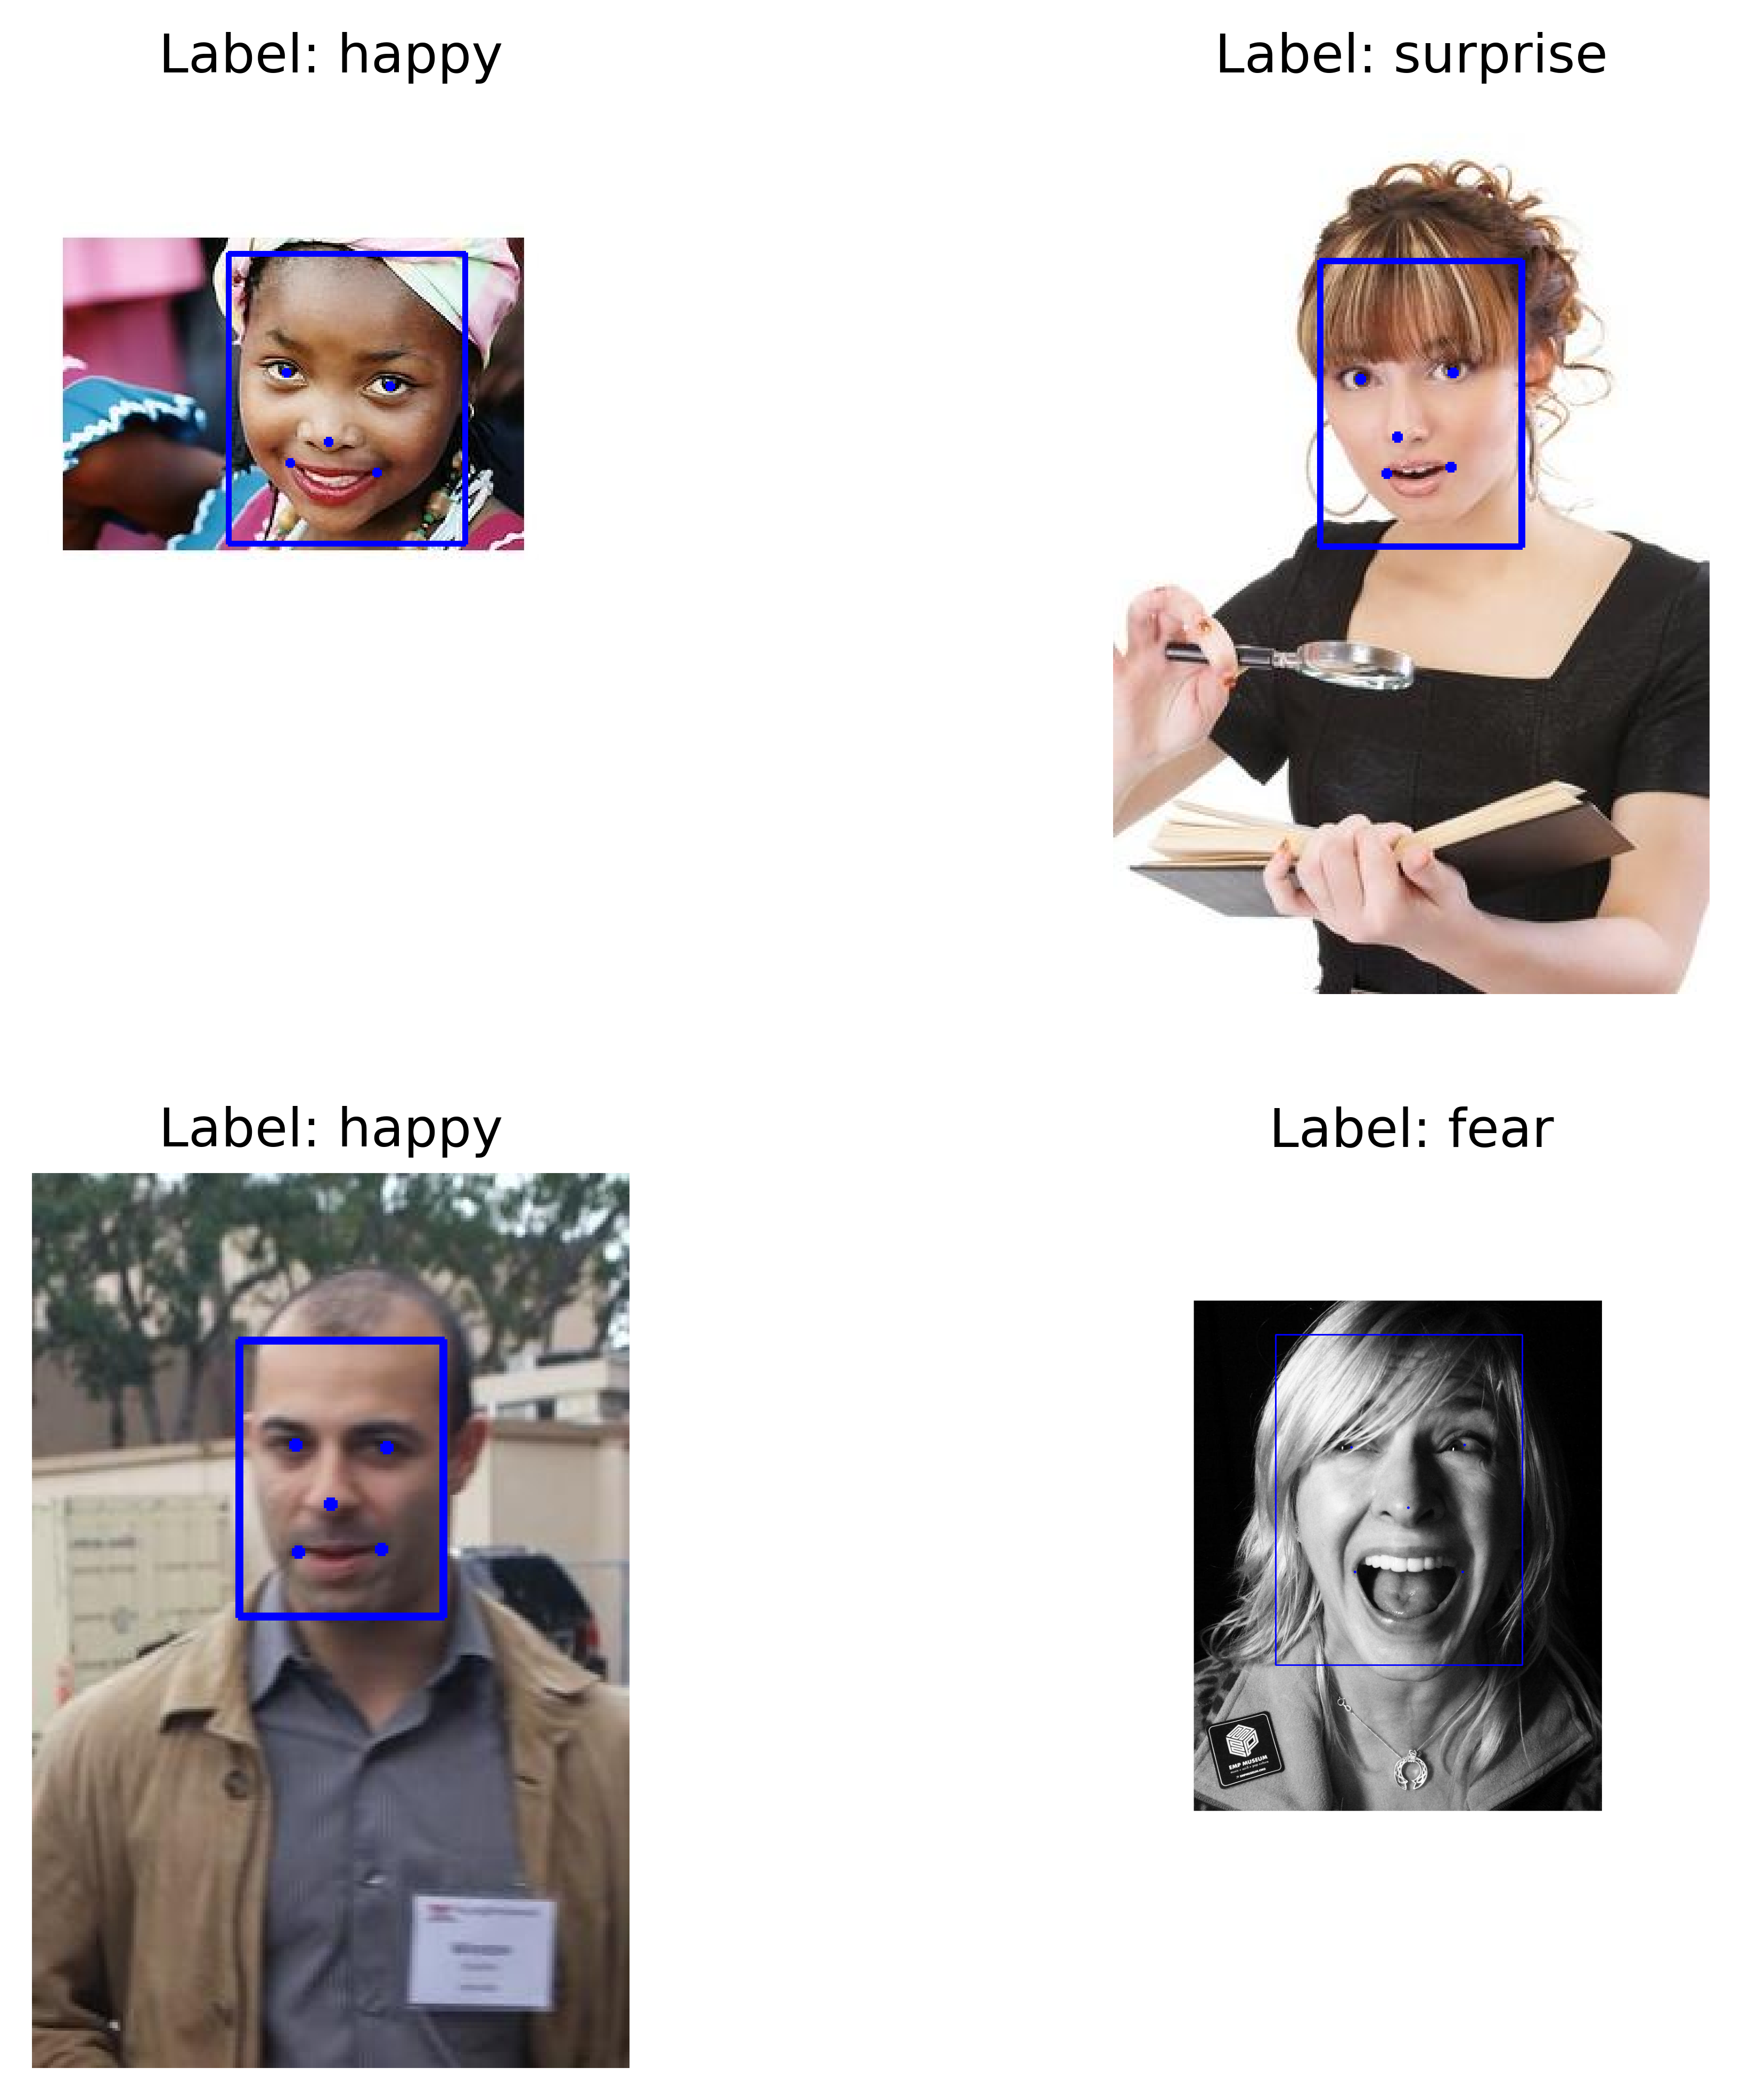

In [14]:
plt.figure(figsize = (8, 8), dpi = 600)
for i in range(4):
    idx = np.random.randint(low = 0, high = len(bounding_boxes))
    image = images[idx]
    label = labels[idx]
    x1, y1, x2, y2 = bounding_boxes[idx]
    landmark_points = landmarks[idx]

    new_image = image.copy()
    new_image = cv2.rectangle(img = new_image, pt1 = (int(x1), int(y1)), pt2 = (int(x2), int(y2)), color = (255, 0, 0), thickness = 2)
    for x, y in landmark_points:
        new_image = cv2.circle(img = new_image, center = (int(x), int(y)), radius = 1, thickness = 2, color = (255, 0, 0))
        
    plt.subplot(2, 2, i + 1)
    plt.imshow(new_image[:, :, ::-1])
    plt.title(f'Label: {label_translation_to_text[label]}')
    plt.axis('off')
plt.show()

### Align and save the images

In [16]:
output_dir = os.path.join('data', 'datasets', 'emotion recognition', 'RAF_DB', 'Images')
os.makedirs(output_dir, exist_ok = True)

In [17]:
landmarks[0]

[[199.247, 219.975],
 [279.609, 212.703],
 [242.677, 270.724],
 [212.525, 311.015],
 [278.481, 307.124]]

In [18]:
aligned_images = []
for i in range(len(images)):
    image = images[i]
    landmark = np.array(landmarks[i])
    bounding_box = np.array(bounding_boxes[i])
    image_name = image_names[i]
    aligned_image = align_face_rotation_bbox(image.copy(), landmarks = landmark, bbox = bounding_box, padding_factor = 0)
    cv2.imwrite(
        os.path.join(output_dir, image_name),
        aligned_image
    )

In [19]:
labels_df = pd.DataFrame(
    data = {
        'filename' : image_names,
        'label' : labels,
        'translated' : translated_labels,
        'split' : train_test_splits
    }
)

labels_df.to_csv(
    os.path.join(os.path.split(output_dir)[0], 'labels.csv'),
    index = False
)

# EDA

In [6]:
labels_df = pd.read_csv(os.path.join('data', 'datasets', 'emotion recognition', 'RAF_DB', 'labels.csv'))

In [7]:
labels_df.head()

,filename,label,translated,split
0,test_0001.jpg,2,sad,test
1,test_0002.jpg,3,surprise,test
2,test_0003.jpg,1,happy,test
3,test_0004.jpg,3,surprise,test
4,test_0005.jpg,2,sad,test


In [8]:
len(labels_df)

15339

In [9]:
classes, counts = np.unique(labels_df.label, return_counts = True)

In [11]:
sorted_idx = np.argsort(counts)
classes = classes[sorted_idx]
classes = [label_translation_to_text[cls] for cls in classes]
counts = counts[sorted_idx]


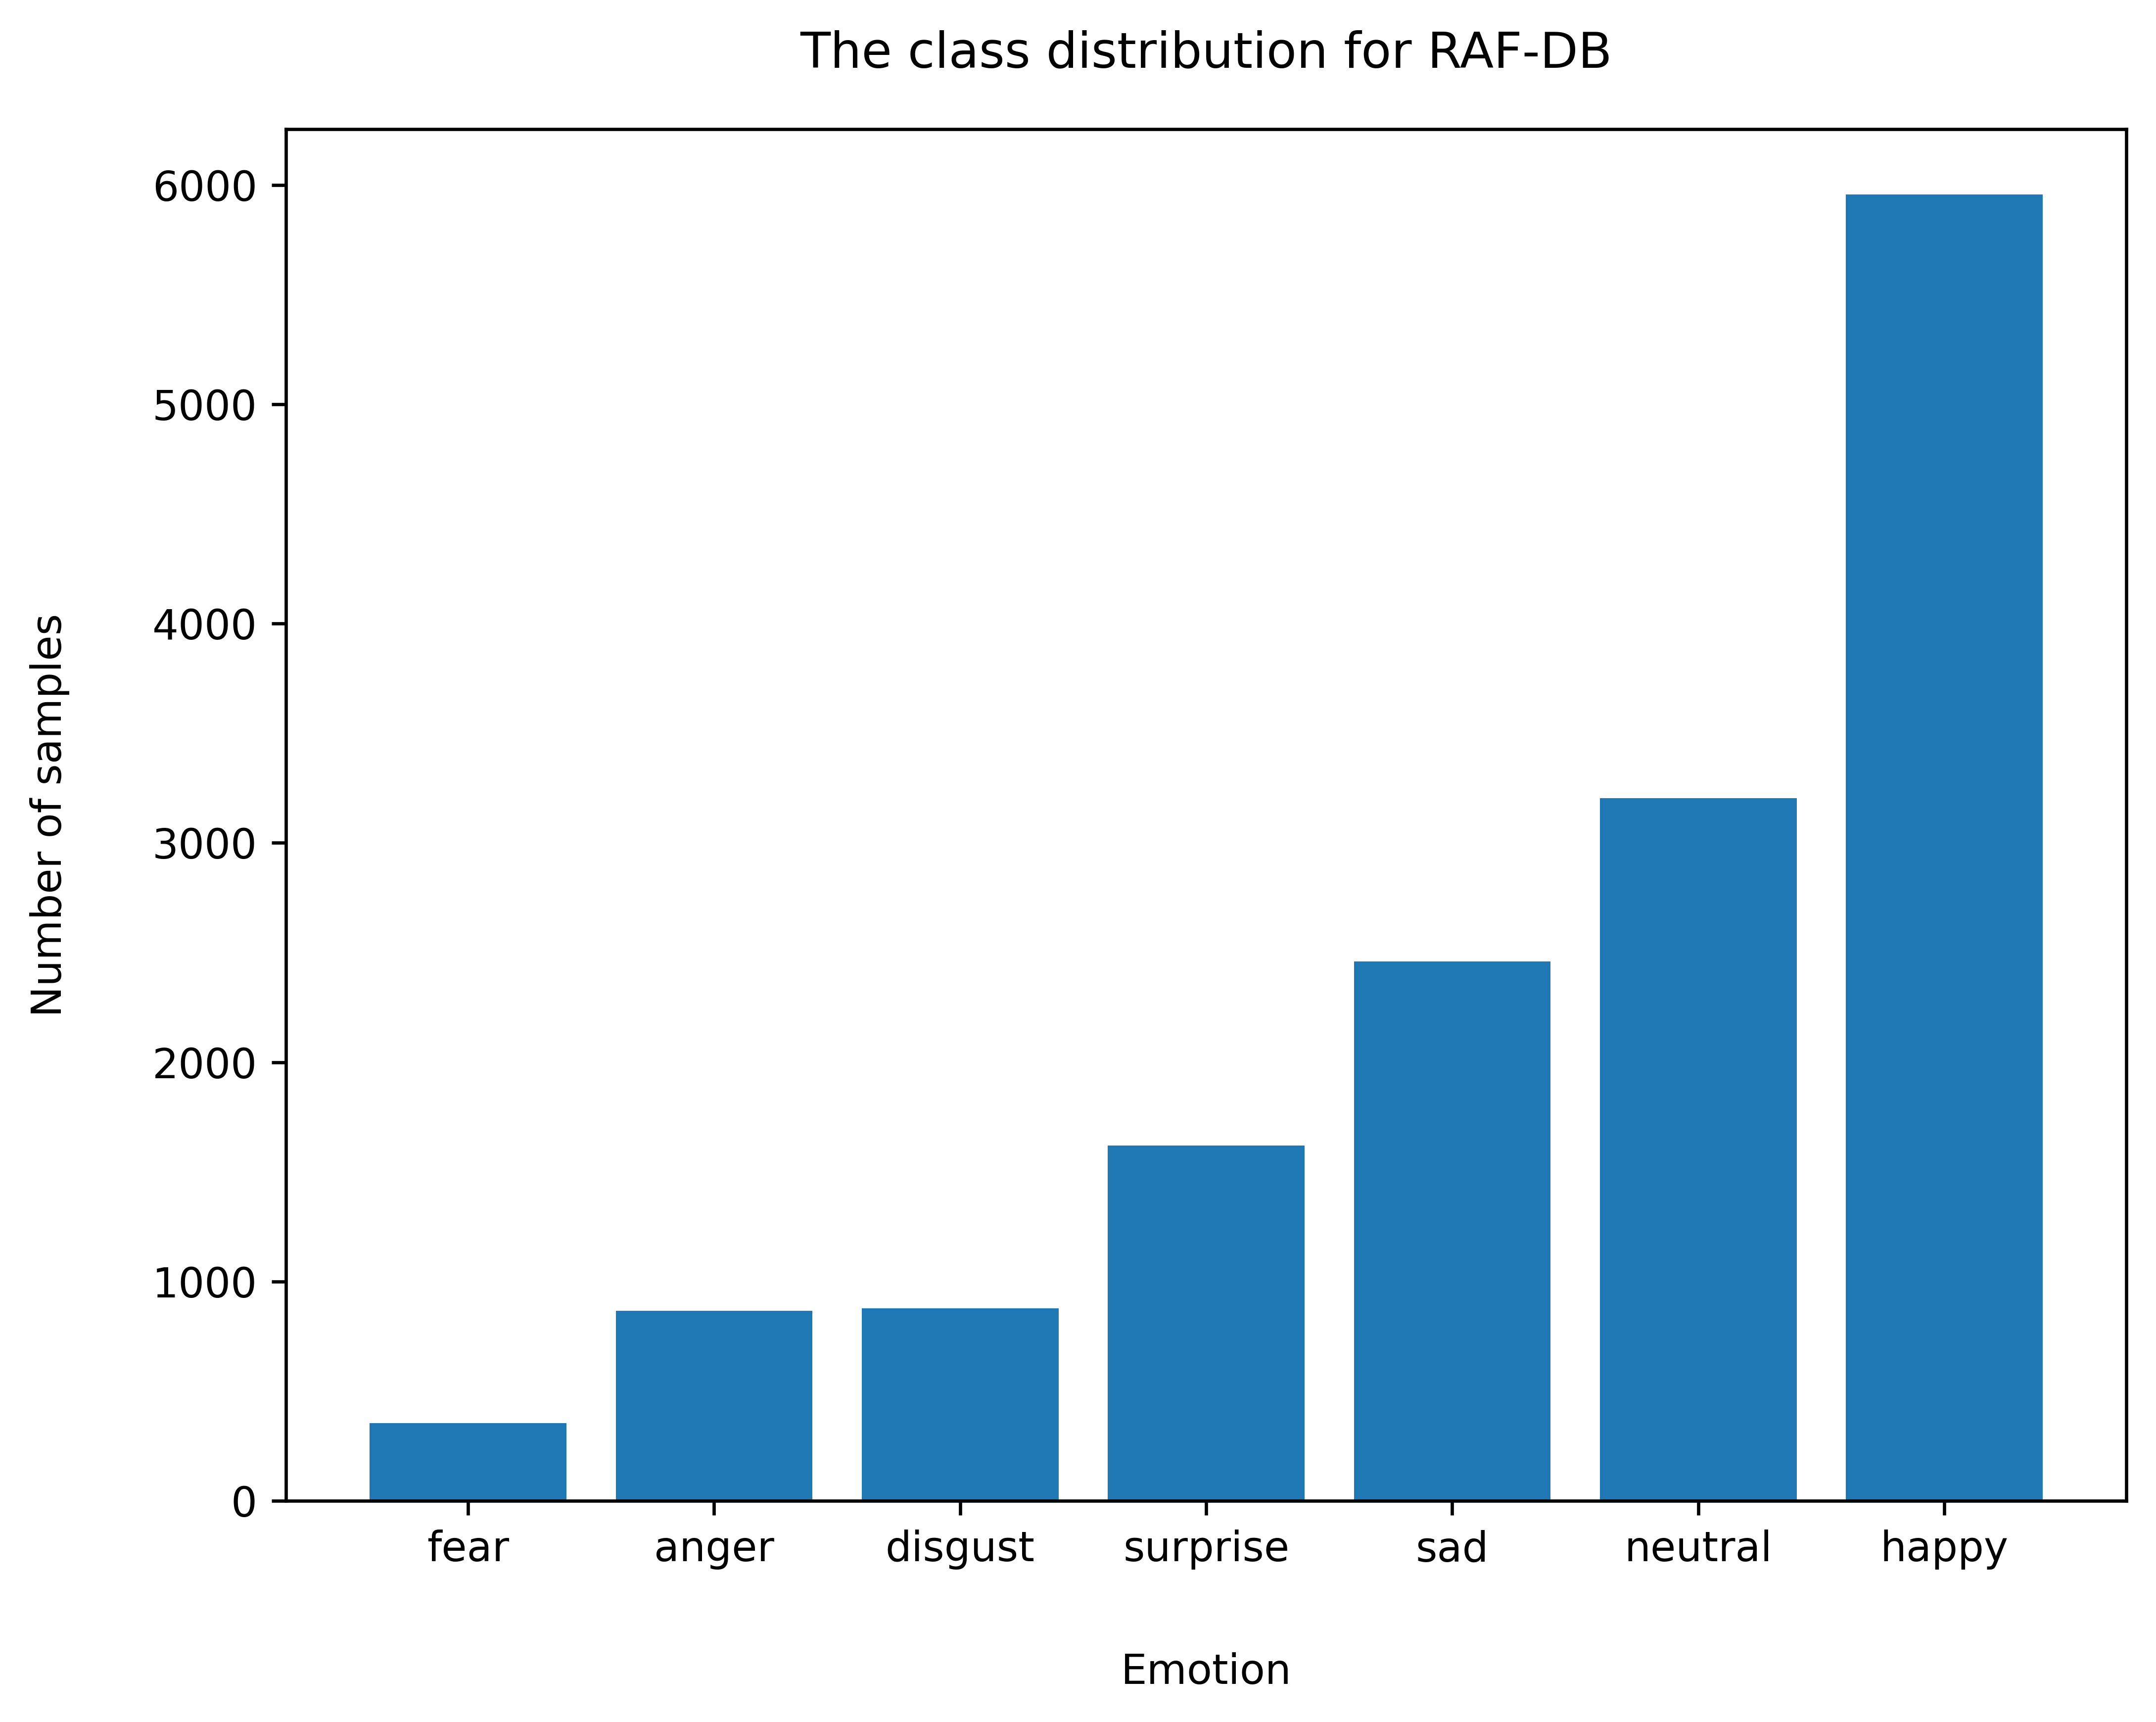

In [14]:
plt.figure(figsize = (8, 6), dpi = 600)
plt.bar(classes, counts)
plt.title('The class distribution for RAF-DB', pad = 15)
plt.xlabel('Emotion', labelpad = 20)
plt.ylabel('Number of samples', labelpad = 20)
plt.savefig(
    os.path.join('data', 'figures', 'Emotion Recognition', 'RAF-DB', 'The distribution of classes for RAF-DB')
)
plt.show()

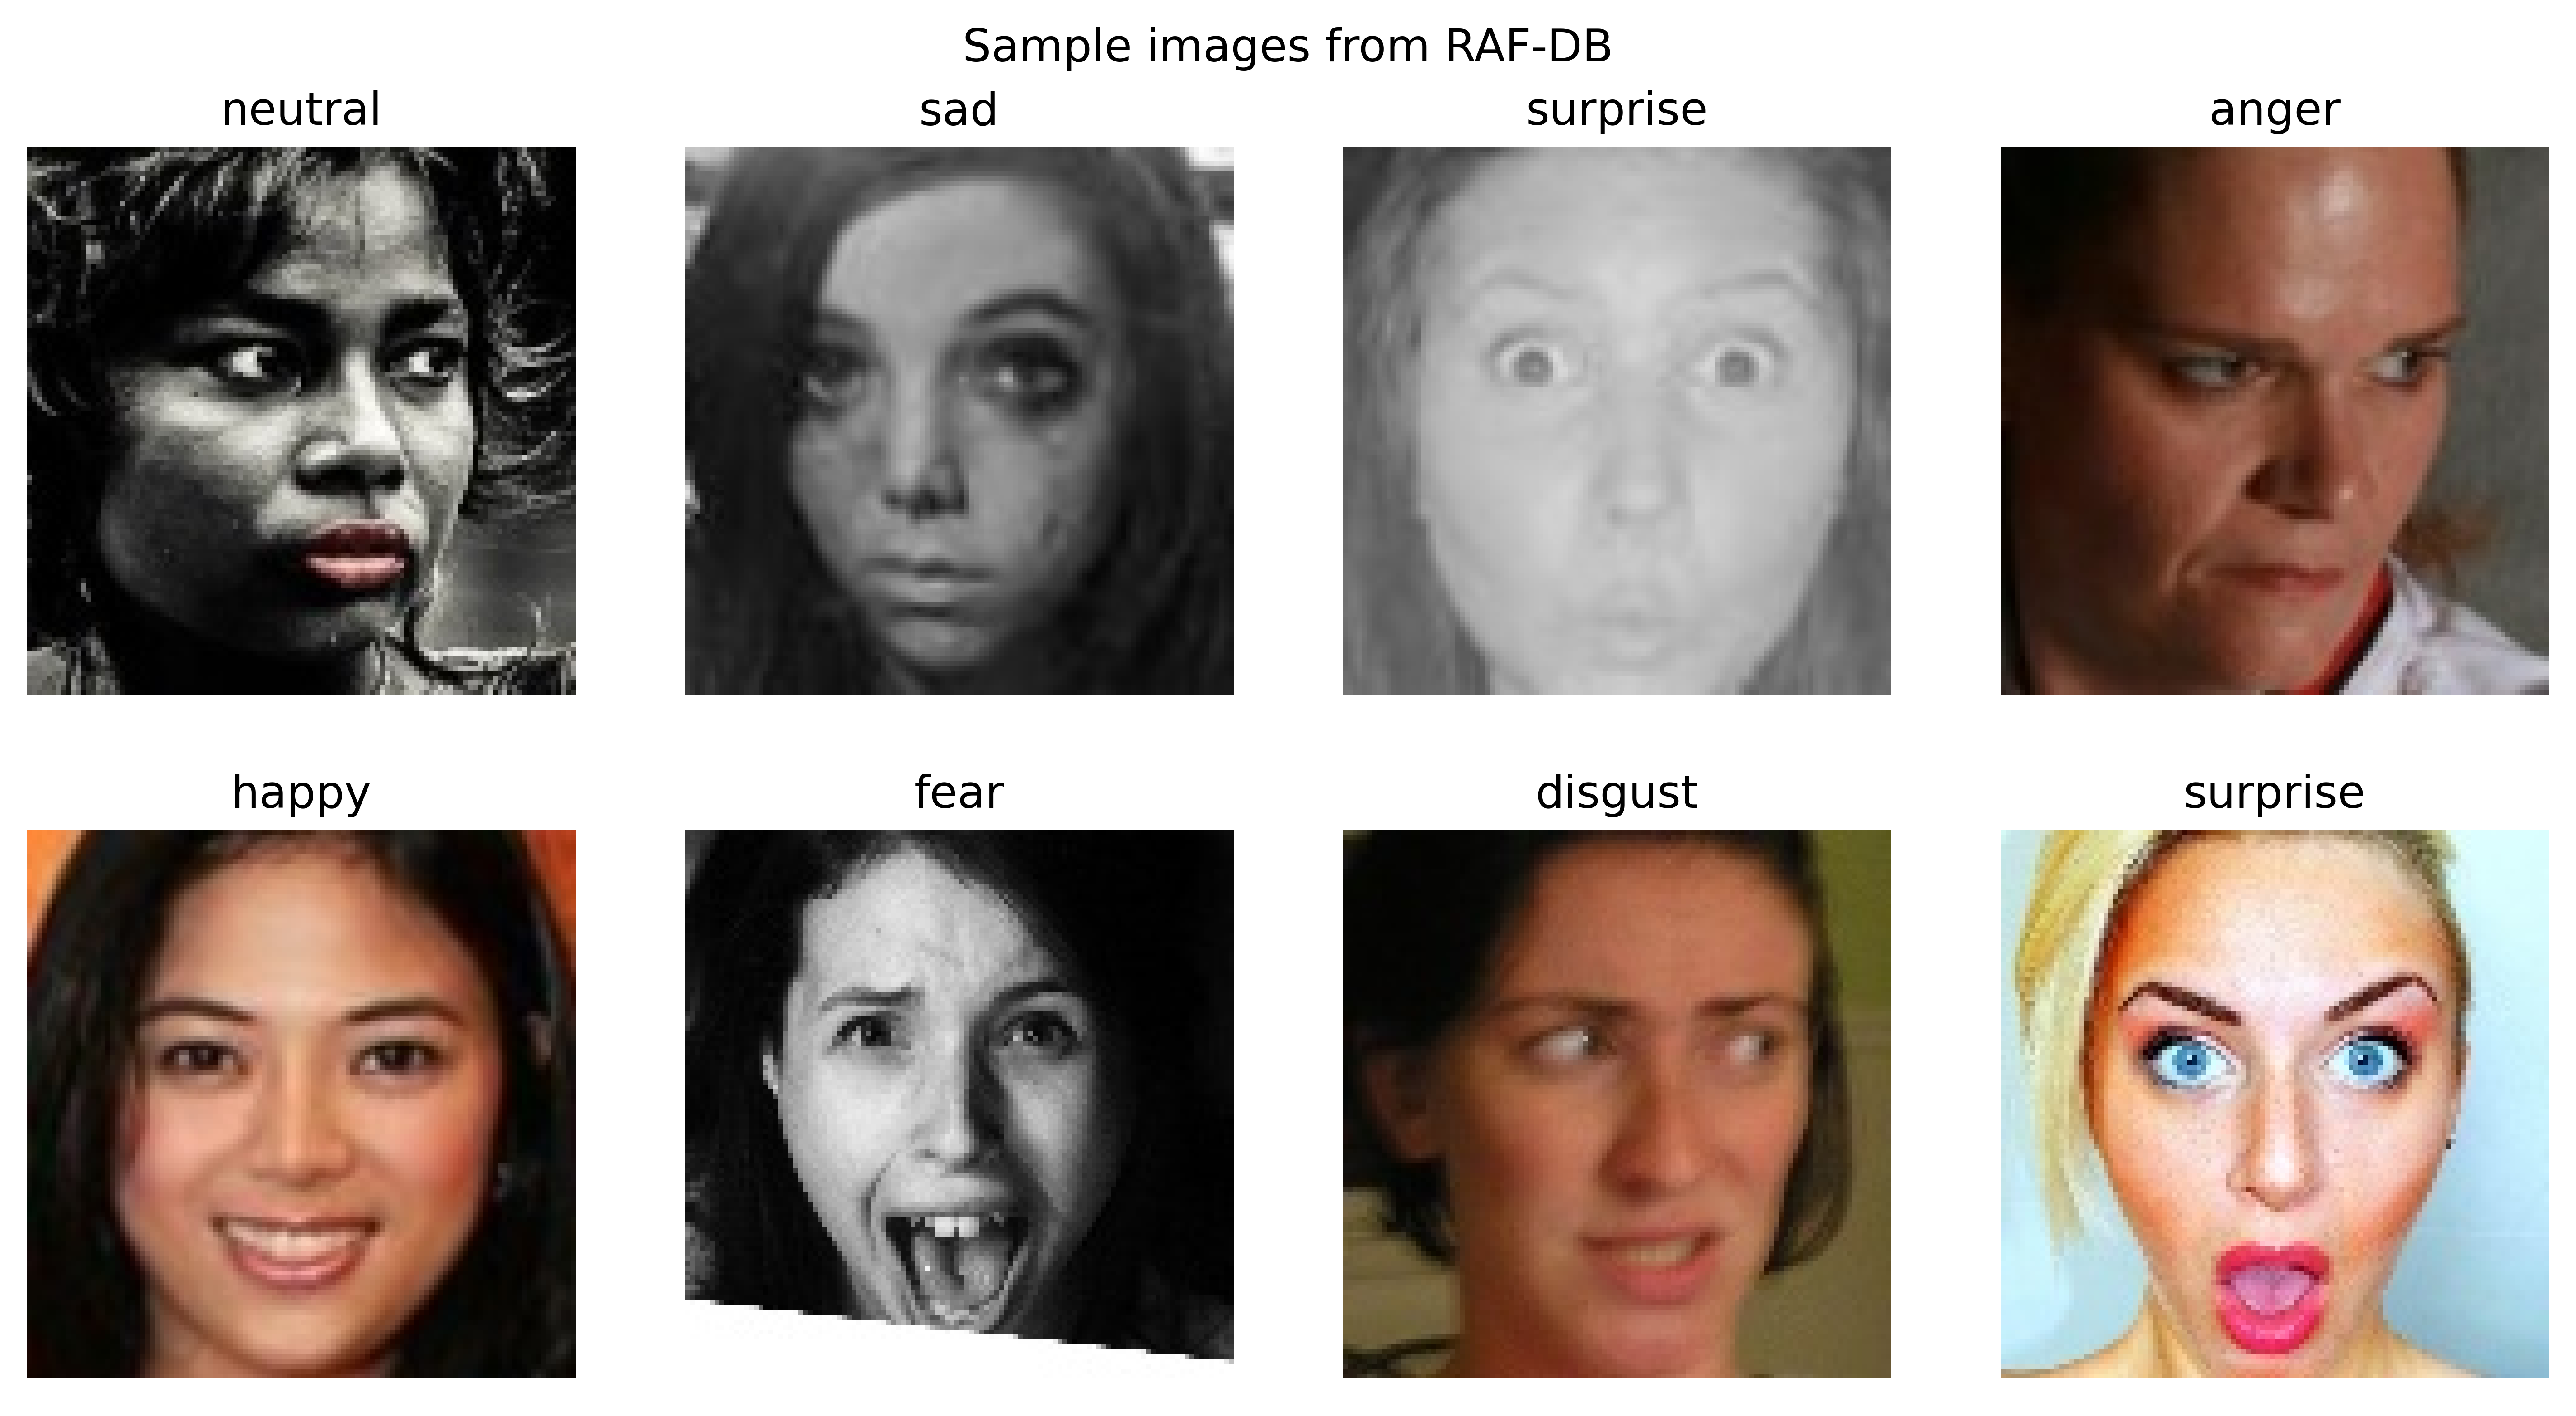

In [26]:
plt.figure(figsize = (12, 6), dpi = 600)
plt.title('Sample images from RAF-DB', pad = 20)
plt.axis('off')

chosen_labels = []
for i in range(8):
    idx = np.random.randint(low = 0, high =len(labels_df))
    label = labels_df['label'][idx]
    while label in chosen_labels: # make sure to show emotions that haven't been shown
        idx = np.random.randint(low = 0, high =len(labels_df))
        label = labels_df['label'][idx]

        if len(chosen_labels) == 7: # since there are only 7 emotions to show, break out of the loop if we got them all
            break
    chosen_labels.append(label)

    filename = labels_df['filename'][idx]
    image = plt.imread(os.path.join(output_dir, filename))
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'{label_translation_to_text[label]}')
plt.savefig(
    os.path.join('data', 'figures', 'Emotion Recognition', 'RAF-DB', 'Sample images from RAF-DB')
)
plt.show()